### Домашнее задание
**Часть 1**

Реализовать функции для поэлементного сложения двух матриц (необходимо замерить время выполнения):

1. На чистом python
2. python + @njit
3. numpy
4. numpy + @njit
5. @cuda.jit

**Часть 2**

Построить график зависимости времени расчета preprocess_array от комбинаций количеcтва ядер и размера батча (использую Colab, поэтому оценивал зависимость только от размера батча).

## Настройка окружения

In [1]:
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/pip-install.py
!pip install -r req.txt

Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 413, done.
remote: Counting objects: 100% (144/144), done.
remote: Compressing objects: 100% (90/90), done.
remote: Total 413 (delta 103), reused 58 (delta 54), pack-reused 269
Receiving objects: 100% (413/413), 113.29 KiB | 5.15 MiB/s, done.
Resolving deltas: 100% (205/205), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 2.1 MB/s eta 0:00:00
***********************************************************************
Woo! Your instance has the right kind of GPU, a Tesla T4!
We will now install RAPIDS cuDF, cuML, and cuGraph via pip! 
Please stand by, should be quick...
***********************************************************************

Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 502.6/502.6 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 GB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## Импорт библиотек

In [2]:
import math
import timeit
import joblib
import numpy as np
import pandas as pd

from numba import jit, njit, cuda
from joblib import Parallel, delayed

## Часть 1

In [3]:
# Создание двух матриц
np_a = np.random.random_sample(90000).reshape(300, 300)
np_b = np.random.random_sample(90000).reshape(300, 300)

In [4]:
def sum_matrix_elwise(matrix_a:np.array, matrix_b:np.array) -> np.array:
    """
    Поэлеметное суммирование матриц на чистом Python.
    """
    assert matrix_a.shape == matrix_b.shape, "The matrices must be of the same size"

    n_rows, n_cols = matrix_a.shape
    sum_matrix = np.zeros(n_rows * n_cols).reshape(n_rows, n_cols)

    for i in range(n_rows):
        for j in range(n_cols):
            sum_matrix[i][j] += matrix_a[i][j] + matrix_b[i][j]

    return sum_matrix
    # return [[matrix_a[i][j] + matrix_b[i][j] for j in range(n_cols)] for i in range(n_rows)]

# Python + @njit
njit_sum_matrix_elwise = njit(sum_matrix_elwise)

def numpy_sum_matrix_elwise(matrix_a:np.array, matrix_b:np.array) -> np.array:
    """
    Поэлеметное суммирование матриц с использованием numpy.
    """
    assert matrix_a.shape == matrix_b.shape, "The matrices must be of the same size"
    return np.add(matrix_a, matrix_b)

# Numpy + @njit
njit_numpy_sum_matrix_elwise = njit(numpy_sum_matrix_elwise)

@cuda.jit
def cuda_sum_matrix_elwise(matrix_a:np.array, matrix_b:np.array, out_sum:np.array) -> np.array:
    """
    Поэлеметное суммирование матриц с использованием cuda.jit
    """
    i, j = cuda.grid(2)
    out_sum[i, j] = matrix_a[i, j] + matrix_b[i, j]

def optimized_sum_matrix_elwise(matrix_a:list, matrix_b:list) -> np.array:
    """
    Поэлеметное суммирование матриц на чистом Python (оптимизированный вариант).
    """
    n_rows, n_cols = len(matrix_a), len(matrix_a[0])
    return np.array([[matrix_a[i][j] + matrix_b[i][j] for j in range(n_cols)] for i in range(n_rows)])

In [5]:
%timeit -r 10 -n 100 sum_matrix_elwise(np_a, np_b)

95.3 ms ± 26.8 ms per loop (mean ± std. dev. of 10 runs, 100 loops each)


In [6]:
%timeit -r 10 -n 100 optimized_sum_matrix_elwise(np_a.tolist(), np_b.tolist())

24.1 ms ± 6.77 ms per loop (mean ± std. dev. of 10 runs, 100 loops each)


In [26]:
%timeit -r 10 -n 1000 njit_sum_matrix_elwise(np_a, np_b)

111 µs ± 11.9 µs per loop (mean ± std. dev. of 10 runs, 1000 loops each)


In [8]:
%timeit -r 10 -n 1000 numpy_sum_matrix_elwise(np_a, np_b)

77.1 µs ± 3.65 µs per loop (mean ± std. dev. of 10 runs, 1000 loops each)


In [25]:
%timeit -r 10 -n 1000 njit_numpy_sum_matrix_elwise(np_a, np_b)

62.2 µs ± 8.8 µs per loop (mean ± std. dev. of 10 runs, 1000 loops each)


In [23]:
# Подготовка перед выполнением функции с использованием cuda.jit
threadsperblock = (32, 32)
blockspergrid_rows = int(math.ceil(np_a.shape[0] / threadsperblock[0]))
blockspergrid_cols = int(math.ceil(np_a.shape[1] / threadsperblock[1]))
blockspergrid = (blockspergrid_rows, blockspergrid_cols)

out_sum = np.zeros(np_a.shape[0] * np_a.shape[1]).reshape(*np_a.shape)

cuda_a   = cuda.to_device(np_a)
cuda_b   = cuda.to_device(np_b)
cuda_out = cuda.to_device(out_sum)

In [24]:
%timeit -r 10 -n 1000 cuda_sum_matrix_elwise[blockspergrid, threadsperblock](cuda_a, cuda_b, cuda_out)

66.5 µs ± 12.9 µs per loop (mean ± std. dev. of 10 runs, 1000 loops each)


**Вывод**

Во втором примере видно, что написание более оптимизированного кода и использование Python-списков достаточно, чтобы уже в несколько раз увеличить скорость выполнения. Это связано с тем, что списковое встраиваение выполняется быстрее, а также получение i-го элемента из Python-списка выполняется значительно быстрее, чем получение i-го элемента из numpy-массива из-за конвертации низкоуровневого представления элемента в numpy-массиве на уровень python.

При использовании декоратора njit наблюдается значительное повышение скорости выполнения функции на чистом Python, поскольку в функции представлены вложенные циклы.

Благодаря векторизации с использованием numpy получаем больший прирост скорости вычислений, чем с декоратором njit над функцией на чистом Python. Аналогично при использовании njit для реализации с помощью numpy, однако наблюдается меньший прирост скорости в сравнении с предыдущим сравнением.

С использованием cuda.jit для вычислений на GPU получается прирост в скорости выполнения примерно в 1.5 раза больше, чем при использовании numpy или numpy + @njit. Данный результат связан с тем, что выполняемая функция хорошо подается распараллеливанию на простые операции.

Также стоит отметить, что скорость выполнения функций c использованием numpy + @njit и @cuda.jit при первом запуске была ниже по сравнению с реализацией посредством только numpy, что вызвано jit-компиляцией в ходе первого запуска, которая занимает достаточно много времени.

**P.S. сравнение времени получения элемента из Python-списка и Numpy-массива**

In [12]:
np_array = np.random.random_sample(90000).reshape(300, 300)
py_list = np_array.tolist()

In [13]:
%timeit -r 10 -n 10000 np_array[104][10]

246 ns ± 40.7 ns per loop (mean ± std. dev. of 10 runs, 10000 loops each)


In [14]:
%timeit -r 10 -n 10000 py_list[104][10]

76 ns ± 28.1 ns per loop (mean ± std. dev. of 10 runs, 10000 loops each)


## Часть 2

In [15]:
x_values = np.random.random_sample(20_000_000)
vector = np.random.random_sample(100)

def preprocess_one(value):
    value = np.sum(np.multiply(vector, value))
    return value ** 2

def preprocess_array(array):
    return [preprocess_one(el) for el in array]

def full_working_cycle(values, batch_size:int, n_jobs:int) -> float:
    batches = [x_values[i:i+batch_size] for i in range(0, len(x_values), batch_size)]

    with Parallel(n_jobs=n_jobs) as parallel:
        interim_results = parallel(delayed(preprocess_array)(batch) for batch in batches)

    results = []
    for batch in interim_results:
        results.extend(batch)

CPU times: user 39.7 ms, sys: 12.1 ms, total: 51.8 ms
Wall time: 54.9 ms


<Axes: xlabel='BATCH_SIZE', ylabel='EXECUTION_TIME, seconds'>

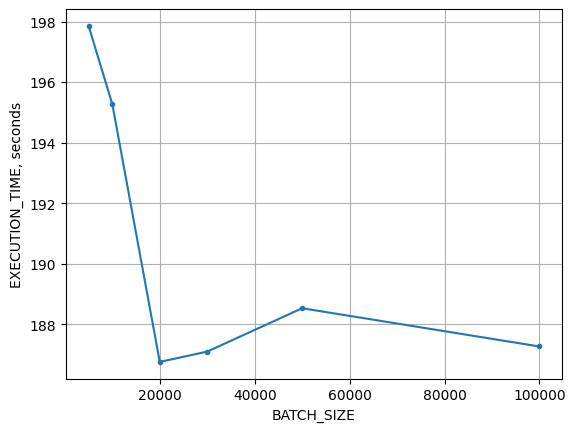

In [22]:
%%time
test_batch_sizes = [5_000, 10_000, 20_000, 30_000, 50_000, 100_000]
execution_times = []

for batch_size in test_batch_sizes:
    execution_times.append(
        timeit.timeit("full_working_cycle(x_values, batch_size, 2)", "from __main__ import full_working_cycle, x_values, batch_size", number=1)
    )

pd.DataFrame({"BATCH_SIZE": test_batch_sizes, "EXECUTION_TIME": execution_times})\
.plot(
    x="BATCH_SIZE", y="EXECUTION_TIME", grid=True, legend=False,
    xlabel="BATCH_SIZE", ylabel="EXECUTION_TIME, seconds", marker="."
)

**Вывод**

На основе графика видно, что при данной конфигурации системы наиболее оптимальным размером батча является 20 000 элементов. Также наблюдается, что выбор маленьких или больших значений размера батча может приводить к замедлению работы функции при реализации параллельных батчевых вычислений, т. е. данный расчет достаточно чувствителен к размеру батча. Вероятно наблюдаемый результат связан с тем, что есть размер массива, который наиболее эффективно может быть векторизован при вычислениях с использованием numpy, что в свою очередь зависит от размера кеша процессора.

Замечание: результаты могут быть не до конца репрезентативными из-за небольшого количества статистики при измерении скорости работы функции при различных значениях гиперпараметров.